<a href="https://colab.research.google.com/github/shobhittya/deeplearning/blob/main/ViT_CASIA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 15.0 MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

**Prepare The Data**

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
dataset_url = "https://www.kaggle.com/sophatvathana/casia-dataset"

In [ ]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shobhittyagi
Your Kaggle Key: ··········


100%|██████████| 5.22G/5.22G [01:23<00:00, 67.4MB/s]


In [271]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt2
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout)
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from keras import regularizers
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau

In [272]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [273]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [274]:
image_size = (128, 128)

In [275]:

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [276]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [277]:

import random
path = '/content/casia-dataset/CASIA1/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
790 790


In [278]:
path = '/content/casia-dataset/CASIA1/Sp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 1000 images
Processing 1500 images
1711 1711


In [279]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [280]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

1368 1368
343 343


In [281]:
model = tf.keras.models.Sequential(
    [
     tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape = (128, 128, 3)),
     tf.keras.layers.MaxPooling2D(2,2),

     tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),

     tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),

     tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),

     tf.keras.layers.Flatten(),

     tf.keras.layers.Dense(512, activation='relu'),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Dense(2, activation='softmax')
     ]
)

In [282]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 256)      

In [283]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [284]:
epochs = 100
batch_size = 16

In [285]:

init_lr = 1e-3
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [286]:
checkpoint = ModelCheckpoint(filepath='/content/Model_weights/MiniNet.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.15, 
                              patience=8, 
                              verbose=1
                             )
csv_logger = CSVLogger('training.log')
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience =5,
                              verbose = 0,
                              mode = 'auto')

callbacks = [checkpoint, reduce_lr, early_stopping, csv_logger]

In [287]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                 verbose = 1, 
                callbacks = callbacks)

Epoch 1/100
86/86 [==============================] - 2s 15ms/step - loss: 0.6688 - accuracy: 0.5687 - val_loss: 0.6894 - val_accuracy: 0.5656

Epoch 00001: val_loss improved from inf to 0.68939, saving model to /content/Model_weights/MiniNet.h5
Epoch 2/100
86/86 [==============================] - 1s 10ms/step - loss: 0.6851 - accuracy: 0.5453 - val_loss: 0.6393 - val_accuracy: 0.6676

Epoch 00002: val_loss improved from 0.68939 to 0.63928, saving model to /content/Model_weights/MiniNet.h5
Epoch 3/100
86/86 [==============================] - 1s 11ms/step - loss: 0.6065 - accuracy: 0.6784 - val_loss: 0.5877 - val_accuracy: 0.6939

Epoch 00003: val_loss improved from 0.63928 to 0.58774, saving model to /content/Model_weights/MiniNet.h5
Epoch 4/100
86/86 [==============================] - 1s 10ms/step - loss: 0.5953 - accuracy: 0.6923 - val_loss: 0.5724 - val_accuracy: 0.7085

Epoch 00004: val_loss improved from 0.58774 to 0.57237, saving model to /content/Model_weights/MiniNet.h5
Epoch 5/

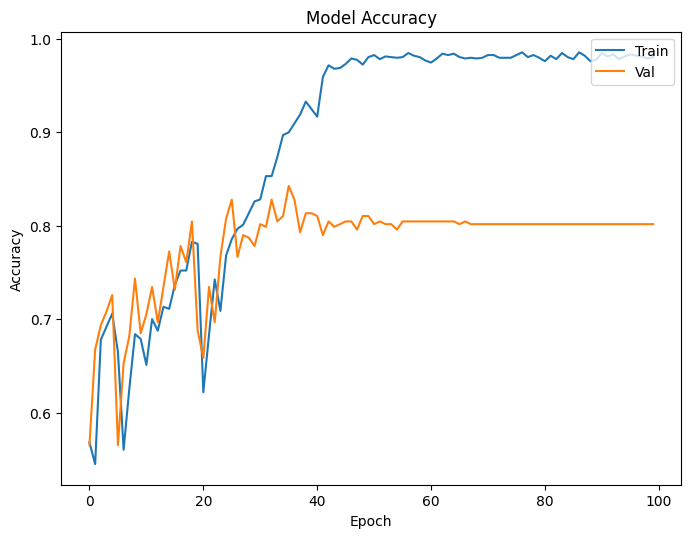

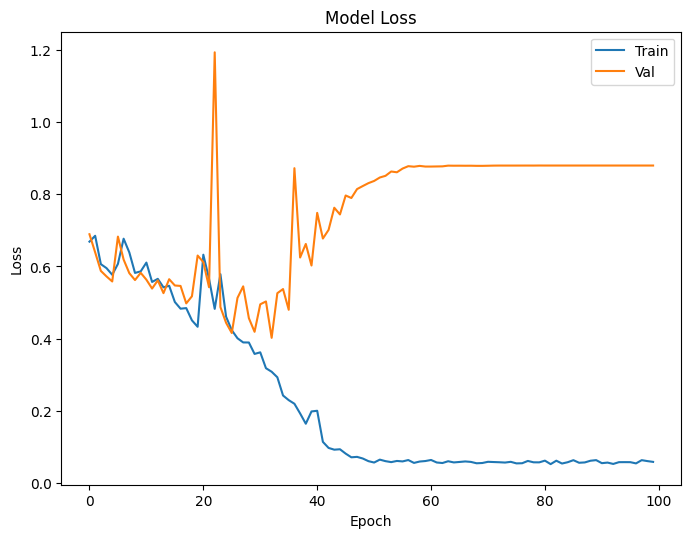

In [289]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [290]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

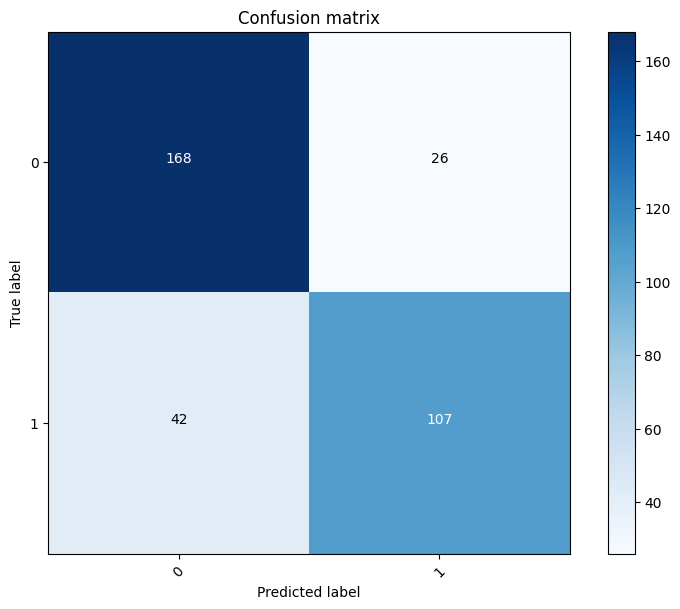

In [291]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))